In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split

import sys
sys.path.insert(0, '..')  # bring the project folder to path
from parameters import *
from utils import *

# The next two lines are to make the notebook use the most updated code on one's computer
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ts_wm_subjs = []
for subj in list(subjects): 
  ts_wm_subjs.append(load_timeseries(subj, 'wm', concat=True, remove_mean=True))

In [3]:
X = np.empty((N_SUBJECTS*4, N_PARCELS))
run = 0

for subj in list(subjects)*4: 
  X[subj, :] = get_condition_bold(subj,'wm','2bk_faces', run, ts_wm_subjs[subj])
  X[N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','0bk_faces', run, ts_wm_subjs[subj])
  X[2*N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','2bk_tools', run, ts_wm_subjs[subj])
  X[3*N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','0bk_tools', run, ts_wm_subjs[subj])

In [4]:
X_test = np.empty((N_SUBJECTS*4, N_PARCELS))
run = 1

for subj in list(subjects)*4:
#   ts_wm = load_timeseries(subj, 'wm', concat=True, remove_mean=True)
  X_test[subj, :] = get_condition_bold(subj,'wm','2bk_faces', run, ts_wm_subjs[subj])
  X_test[N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','0bk_faces', run, ts_wm_subjs[subj])
  X_test[2*N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','2bk_tools', run, ts_wm_subjs[subj])
  X_test[3*N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','0bk_tools', run, ts_wm_subjs[subj])

In [61]:
y_te = train_test_split(X, y)[3]
np.sum(y_te ==1)/np.sum(y_te ==0)

0.9261363636363636

(1356, 360)
(1356, 360)


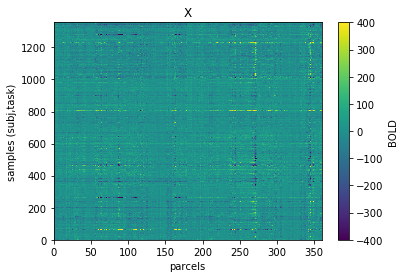

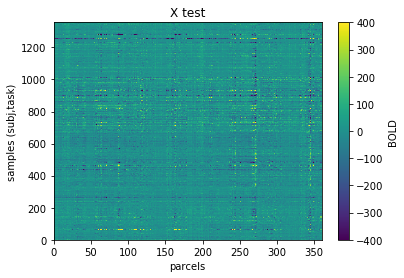

In [41]:
    def plot_X(X, custom_title=None, vmin=None, vmax=None):
        print(X.shape)
        plt.figure()
        plt.pcolormesh(X, vmin=vmin, vmax=vmax)
        plt.colorbar(label= "BOLD")
        plt.ylabel('samples (subj,task)')
        plt.xlabel('parcels')
        if not custom_title:
            plt.title('X')
        else:
            plt.title(custom_title)

plot_X(X, vmin=-400, vmax=400)
plot_X(X_test, vmin=-400, vmax=400, custom_title='X test')

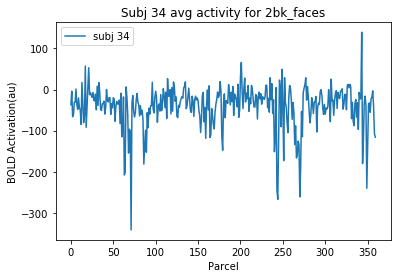

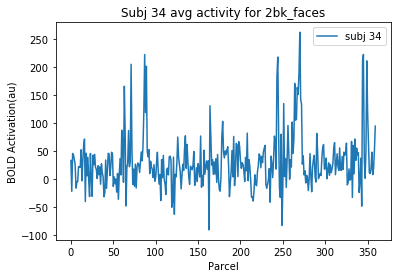

In [63]:
def plot_avg_bold(subj, X):
    plt.figure()
    ax=plt.plot(X[subj,:], label=f'subj {subj}') # 39 frames

    plt.title(f'Subj {subj} avg activity for 2bk_faces')
    plt.xlabel('Parcel')
    plt.ylabel('BOLD Activation(au)')
    plt.legend()

    plt.show()
    
subj = 34
plot_avg_bold(subj, X)

plot_avg_bold(subj, X_test)


In [43]:
y = np.concatenate(([0]*N_SUBJECTS*2,[1]*N_SUBJECTS*2))
y.shape

(1356,)

In [79]:
def normalize_matrix(mat):
    return (mat+abs(mat.min()))/(mat.max()-mat.min())

normalize_matrix(np.array([-1,4,2]))

array([0. , 1. , 0.6])

(1356, 360)
(1356, 360)


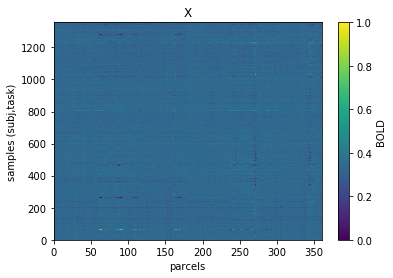

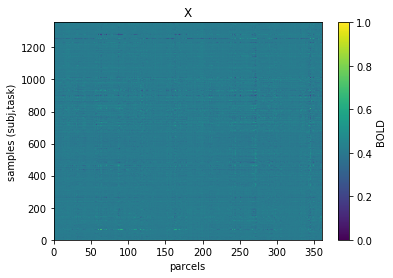

In [81]:
X_prep = normalize_matrix(X)
X_prep_test = normalize_matrix(X_test)

plot_X(X_prep)
plot_X(X_prep_test)

## Regression - no regularization

In [82]:
# First define the model
log_reg = LogisticRegression(penalty="none")

#Then fit it to data
log_reg.fit(X_prep, y)

acc_train = np.mean(log_reg.predict(X_prep)==y)
print("Accuracy for training set =", acc_train)
predictions = log_reg.predict(X_prep)

Accuracy for training set = 1.0


In [83]:
np.mean(log_reg.predict(X_prep_test)==y)

0.15855457227138642

In [90]:
# First define the model
log_reg = LogisticRegression(penalty="none")

#Then fit it to data
log_reg.fit(X, y)

acc_train = np.mean(log_reg.predict(X)==y)
print("Accuracy for training set =", acc_train)
predictions = log_reg.predict(X)
print("Accuracy for test set =", np.mean(log_reg.predict(X_test)==y))

Accuracy for training set = 1.0
Accuracy for test set = 0.3001474926253687


(1, 360)


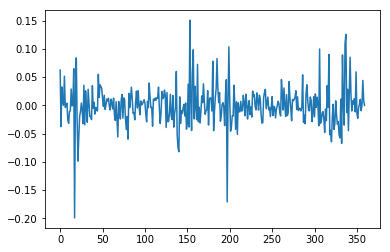

In [61]:
print(log_reg.coef_.shape)
# print(log_reg.coef_)
plt.plot(log_reg.coef_[0, :]);

In [86]:
log_reg.intercept_

array([310.77049421])

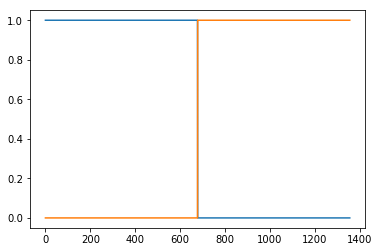

In [14]:
plt.plot(log_reg.predict_proba(X))

In [1]:
1/8, 7/8

(0.125, 0.875)

[0.99411765 0.97647059 0.97647059 0.98235294 0.95857988 0.96449704
 0.96449704 0.98224852]


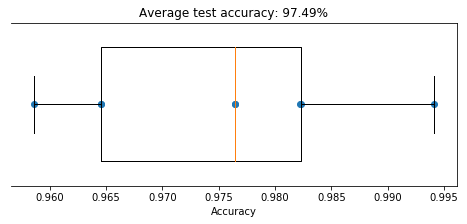

In [15]:
kfold=8  # k-fold crossvalidation
accuracies = cross_val_score(log_reg, X, y, cv=kfold) # k=8 crossvalidation

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(kfold))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)
print(accuracies)

## L1 regularization

In [94]:
log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
log_reg_l1.fit(X_prep, y)
acc_train_l1 = np.mean(log_reg_l1.predict(X_prep)==y)
print("Accuracy for training set =", acc_train_l1)
print("Accuracy for test set =", np.mean(log_reg_l1.predict(X_prep_test)==y))

Accuracy for training set = 0.9800884955752213
Accuracy for test set = 0.27728613569321536


In [93]:
log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
log_reg_l1.fit(X, y)
acc_train_l1 = np.mean(log_reg_l1.predict(X)==y)
print("Accuracy for training set =", acc_train_l1)
print("Accuracy for test set =", np.mean(log_reg_l1.predict(X_test)==y))

Accuracy for training set = 1.0
Accuracy for test set = 0.3274336283185841


In [92]:
np.mean(log_reg_l1.predict(X_test)==y)

0.32669616519174044

(1, 360)


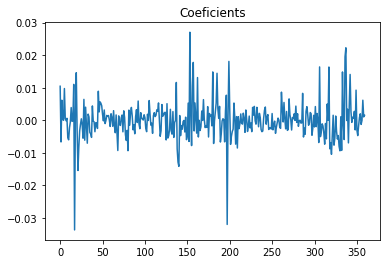

In [28]:
plt.title('Coeficients')
plt.plot(log_reg_l1.coef_[0, :]);
print(log_reg_l1.coef_.shape)

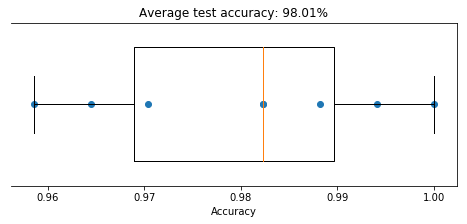

In [17]:
kfold=8  # k-fold crossvalidation
accuracies_l1 = cross_val_score(log_reg_l1, X, y, cv=kfold) # k=8 crossvalidation

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies_l1, vert=False, widths=.7)
ax.scatter(accuracies_l1, np.ones(kfold))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies_l1.mean():.2%}"
)
ax.spines["left"].set_visible(False)

## L2

In [67]:
log_reg_l2 = LogisticRegression(penalty="l2", C=1)
log_reg_l2.fit(X, y)
acc_train_l2 = np.mean(log_reg_l2.predict(X)==y)
print("Accuracy for training set =", acc_train_l2)
predictions_l2 = log_reg_l2.predict(X)

Accuracy for training set = 1.0


/home/homero/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


/home/homero/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/homero/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

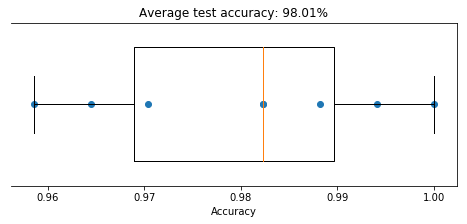

In [69]:
kfold=8  # k-fold crossvalidation
accuracies_l2 = cross_val_score(log_reg_l2, X, y, cv=kfold) # k=8 crossvalidation

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies_l1, vert=False, widths=.7)
ax.scatter(accuracies_l1, np.ones(kfold))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies_l1.mean():.2%}"
)
ax.spines["left"].set_visible(False)